# Importing the dataset from Kaggle

In [ ]:
# Importing the dataset from kaggle
! pip install kaggle; 
! mkdir ~/.kaggle ;
! cp kaggle.json ~/.kaggle/ ;
! chmod 600 ~/.kaggle/kaggle.json ;
! kaggle datasets download srbhshinde/flickr8k-sau --force; 
! unzip flickr8k-sau.zip;

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k-sau/Flickr_Data/Images/2844747252_64567cf14a.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k-sau/Flickr_Data/Images/2848266893_9693c66275.jpg  


In [ ]:
from glob import glob
import numpy as np
import pandas as pd
import cv2
import os

In [ ]:
images_path = 'Flickr_Data/Images/'
images = glob(images_path+'*.jpg') 
# glob returns a possibly-empty list of path names that match pathname, which must be a string containing a path specification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the ResNet50 Model for extracting features from the images

In [ ]:
from tensorflow.keras.applications import ResNet50  
resnet_model = ResNet50(include_top=True)
 
# ResNet stands for Residual Network.
# Resnet50 is used to denote the variant that can work with 50 neural network layers.

102981632/102967424 [==============================] - 2s 0us/step


In [ ]:
from keras.models import Model
last = resnet_model.layers[-2].output
model_resnet = Model(inputs = resnet_model.input,outputs = last)
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
image_features = {}
ctr = 0
for image in images:
  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))
  img = img.reshape(1,224,224,3)
  pred = model_resnet.predict(img).reshape(2048,)
  img_name = image.split('/')[-1]
  image_features[img_name] = pred
  ctr += 1
  if ctr>1499:
      break
      
  

In [ ]:
len(image_features)

1500

# Creating a Vocabulary of Captions for images from the dataset

In [ ]:
caption_path = 'Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [ ]:
captions_dict = {}
for cap in captions:
  try:
    img_name = cap.split('\t')[0][:-2] 
    caption = cap.split('\t')[1]
    if img_name in image_features:
      if img_name not in captions_dict:
        captions_dict[img_name] = [caption]
      else:
        captions_dict[img_name].append(caption)
  except:
    pass

In [ ]:
len(captions_dict)

1500



```
# This is formatted as code
```

# Plotting 4 images along with their captions after preprocessing


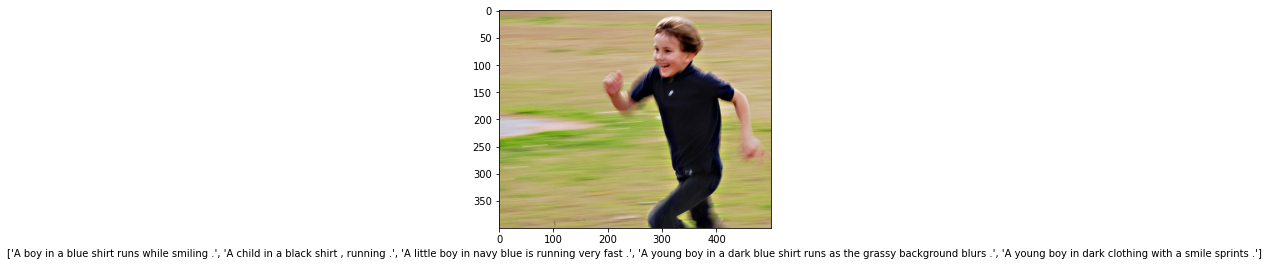

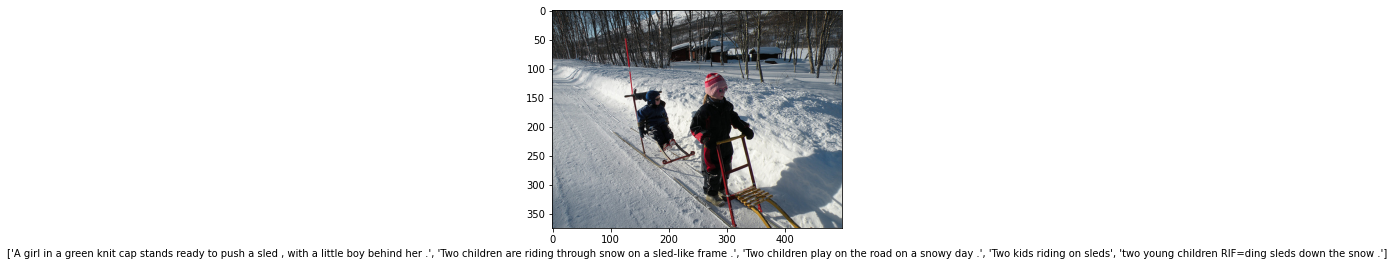

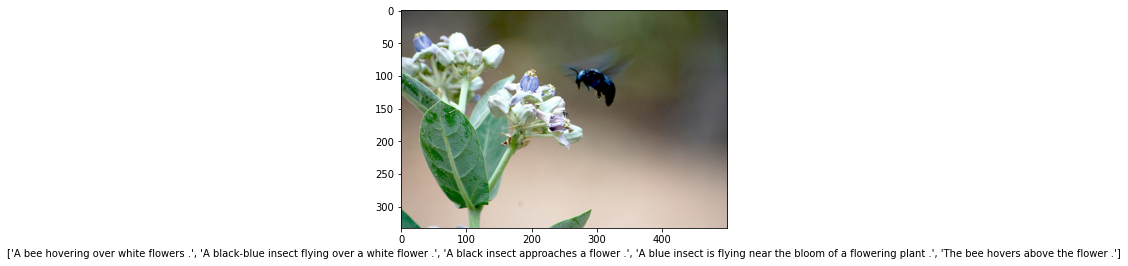

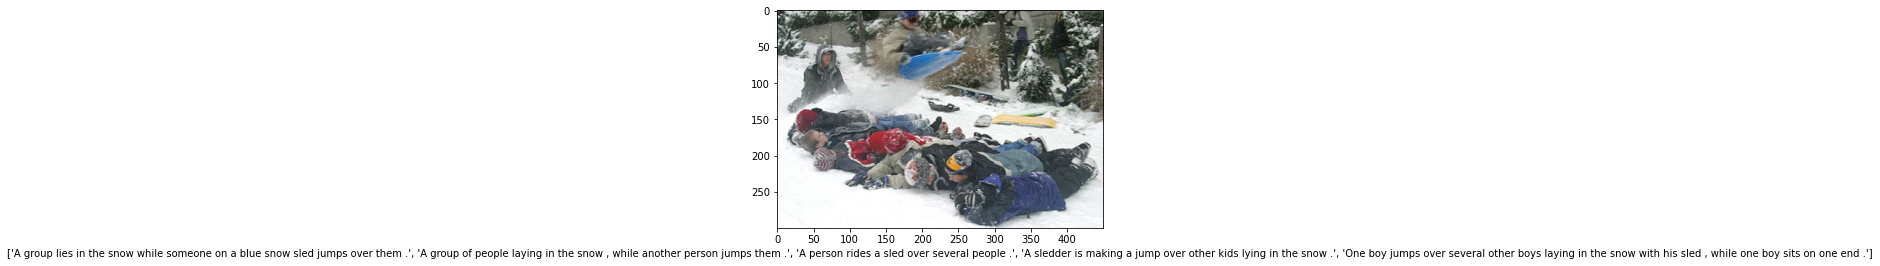

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
  plt.figure()
  img_name = images[i]
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.xlabel(captions_dict[img_name.split('/')[-1]])
  plt.imshow(img)

In [ ]:
for ind,cap in captions_dict.items():
  for cap_ind in cap:
    cap_ind_new = cap_ind.lower()
    cap_ind_new = 'startofseq ' + cap_ind_new + ' endofseq'
    captions_dict[ind][cap.index(cap_ind)] = cap_ind_new

In [ ]:
count_words = {}
for ind,cap_ind in captions_dict.items():
  for cap in cap_ind:
    for word in cap.split():
      if word not in count_words:
        count_words[word] = 0
      else:
        count_words[word] += 1

In [ ]:
THRESHOLD = -1
ctr = 1
new_dict = {}
for ind,cap in count_words.items():
  if count_words[ind] > THRESHOLD:
    new_dict[ind] = ctr
    ctr += 1

In [ ]:
new_dict['<OUT>'] = len(new_dict)
captions_backup = captions_dict.copy()
captions_dict = captions_backup.copy()

# The Dictionary of Caption encodings for each image

In [ ]:
for ind, cap in captions_dict.items():
  for cap_ind in cap:
    encoded = []
    for word in cap_ind.split():  
      if word not in new_dict:
        encoded.append(new_dict['<OUT>'])
      else:
        encoded.append(new_dict[word])


    captions_dict[ind][cap.index(cap_ind)] = encoded

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 0
for cap, cap in captions_dict.items():
  for cap_ind in cap:
    if len(cap_ind) > MAX_LEN:
      MAX_LEN = len(cap_ind)
      #print(cap_ind)

In [ ]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(image, caption):
    n_samples = 0
    X = []
    y_in = []
    y_out = []
    
    for cap, ind in caption.items():
        for cap_ind in ind:
            for i in range(1, len(cap_ind)):
                X.append(image[cap])

                in_seq= [cap_ind[:i]]
                out_seq = cap_ind[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
          
  #return X, y_in, y_out

X,y_in,y_out = generator(image_features, captions_dict)

X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

# Creating the Model

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Model, Sequential
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
embedding_size = 256 #128
max_len = MAX_LEN
vocab_size = len(new_dict)
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))
image_model.summary()
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(LSTM(128, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))
language_model.summary()
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(256, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 repeat_vector (RepeatVector  (None, 35, 256)          0         
 )                                                               
                                                                 
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 256)           1029120   
                                                                 
 lstm (LSTM)                 (None, 35, 256)           525312    
                            

# Training the Model

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=70)

Epoch 1/70
187/187 [==============================] - 55s 249ms/step - loss: 5.0392 - accuracy: 0.1788
Epoch 2/70
187/187 [==============================] - 46s 247ms/step - loss: 4.4478 - accuracy: 0.2514
Epoch 3/70
187/187 [==============================] - 46s 247ms/step - loss: 4.2617 - accuracy: 0.2641
Epoch 4/70
187/187 [==============================] - 46s 246ms/step - loss: 4.0415 - accuracy: 0.2841
Epoch 5/70
187/187 [==============================] - 46s 247ms/step - loss: 3.7711 - accuracy: 0.3112
Epoch 6/70
187/187 [==============================] - 46s 246ms/step - loss: 3.5665 - accuracy: 0.3355
Epoch 7/70
187/187 [==============================] - 46s 246ms/step - loss: 3.4051 - accuracy: 0.3547
Epoch 8/70
187/187 [==============================] - 46s 246ms/step - loss: 3.2843 - accuracy: 0.3672
Epoch 9/70
187/187 [==============================] - 46s 246ms/step - loss: 3.1758 - accuracy: 0.3790
Epoch 10/70
187/187 [==============================] - 46s 246ms/step - l

# Saving the Model

In [ ]:
inv_dict = {cap:i for i, cap in new_dict.items()}
model.save('image_caption_generator_model.h5')
model.save_weights('model_weights.h5')
np.save('vocab.npy', new_dict)

# Making Predictions

In [ ]:
## load model
from keras.models import load_model
model.save('drive/MyDrive/Models/CSE4020_ML_PROJECT/image_caption_generator_model.h5')
model.save_weights('drive/MyDrive/Models/CSE4020_ML_PROJECT/')
np.save('drive/MyDrive/Models/CSE4020_ML_PROJECT/vocab.npy', new_dict)
#model = load_model('drive/MyDrive/Models/CSE4020_ML_PROJECT/image_caption_generator_model.h5')
#model.load_weights('drive/MyDrive/Models/CSE4020_ML_PROJECT/')

model = load_model('/content/image_caption_generator_model.h5')
model.load_weights('/content/model_weights.h5')


# model.load_weights("../input/model_weights.h5")

In [ ]:
def import_image(x):  
  img_path = images[x]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(224,224))
  img = np.reshape(img,(1,224,224,3))
  return img

# Predictions of 4 random images from the dataset

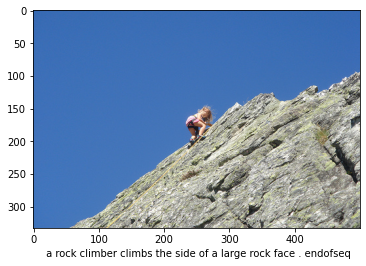

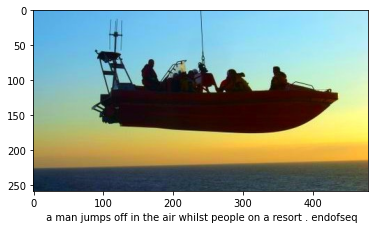

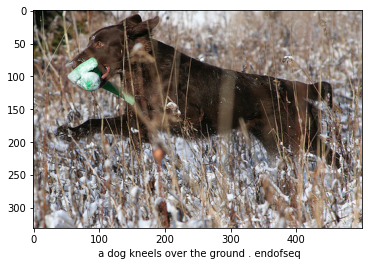

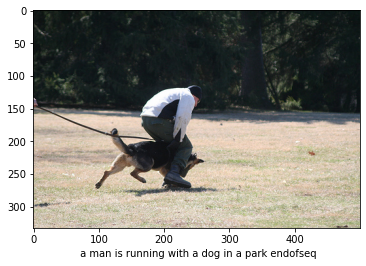

In [ ]:
for i in range(4):  
  no = np.random.randint(1500,7000,(1,1))[0,0]
  test_feature = model_resnet.predict(import_image(no)).reshape(1,2048)
  img_path = images[no]
  test_img = cv2.imread(img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  text_inp = ['startofseq']
  count = 0
  caption = ''
  while count < 25:
    count += 1
    encoded = []
    for i in text_inp:
      encoded.append(new_dict[i])

    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    prediction = np.argmax(model.predict([test_feature, encoded]))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word 
    if sampled_word == 'endofseq':
      break
    text_inp.append(sampled_word)
      
  plt.figure()
  plt.imshow(test_img)
  plt.xlabel(caption)

Text(0.5, 0, ' a young girl with a white shirt is looking at something and looking at the camera . . .')

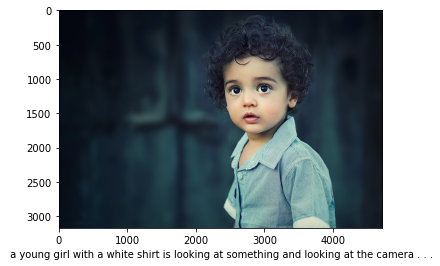

In [ ]:
# test_image = cv2.imread('/content/pexels-anand-dandekar-1532771.jpg')
test_image = cv2.imread('drive/MyDrive/Images/image1.jpg')
image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224,224))
image = np.reshape(image, (1,224,224,3))

test_feature = model_resnet.predict(image).reshape(1,2048)

text_in = ['startofseq']

final = ''

count = 0
while count < 25:

        count += 1

        encoded = []
        for i in text_in:
            encoded.append(new_dict[i])
        
        encoded = [encoded]
        padded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
        # padded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post').reshape(1,max_len)

        sampled_index = np.argmax(model.predict([test_feature, padded]))

        sampled_word = inv_dict[sampled_index]
        if sampled_word != 'endofseq':
            final = final + ' ' + sampled_word
        text_in.append(sampled_word)

text_in
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.xlabel(final)

# ADDED ALGORITHMS AND FUNCTIONALITIES

In [ ]:
!pip install gTTS

## AUDIO GENERATION

In [ ]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
tts = gTTS(final) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
#if 10<11:
Audio(sound_file, autoplay=True)

## SENTIMENT ANALYSIS

In [ ]:
! pip install transformers
from transformers import pipeline
#classifier = pipeline('sentiment-analysis')
classifier = pipeline('sentiment-analysis', model="cardiffnlp/twitter-roberta-base-sentiment")

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 45.2 MB/s 
     |████████████████████████████████| 3.3 MB 34.8 MB/s 
     |████████████████████████████████| 61 kB 476 kB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Sentiment

cl = classifier(caption)
for l in cl:
  if l['label']=="LABEL_0":
    print("Negative")
  elif l['label']=="LABEL_1":
    print("Neutral")
  if l['label']=="LABEL_2":
    print("Positive")


Neutral


## SECURITY ALERT

In [ ]:
word_dict = ['man','person','woman','running','walking','standing']

caption = final
caption_temp=caption
caption = caption.split(' ')
for word in caption:
  if word in word_dict:
    print("Alert")
    

## CENSORSHIP

In [ ]:
def censor(captions):
  res = classifier(captions)
  for inc in res:
    if inc['label']=="Label_0":
      print("Not Appropriate")
      

In [ ]:
print("Alert")

Alert
